# Global imports

In [1]:
# External imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import Counter

# Sklearn imports
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.multiclass import OneVsRestClassifier

# Customized score functions
from qksvm.scores import get_scores, print_scores, print_cv_scores
from qksvm.visualization_tools import plot_dataset, plot_predictions, plot_decisions
from qksvm.QuantumFeatureMap import QuantumFeatureMap
from qksvm.QKSVM import QSVC
from qksvm.qksvc import QKSVC

seed = 12345
np.random.seed(seed)

# Dataset

In [2]:
# Load data
iris = load_iris()

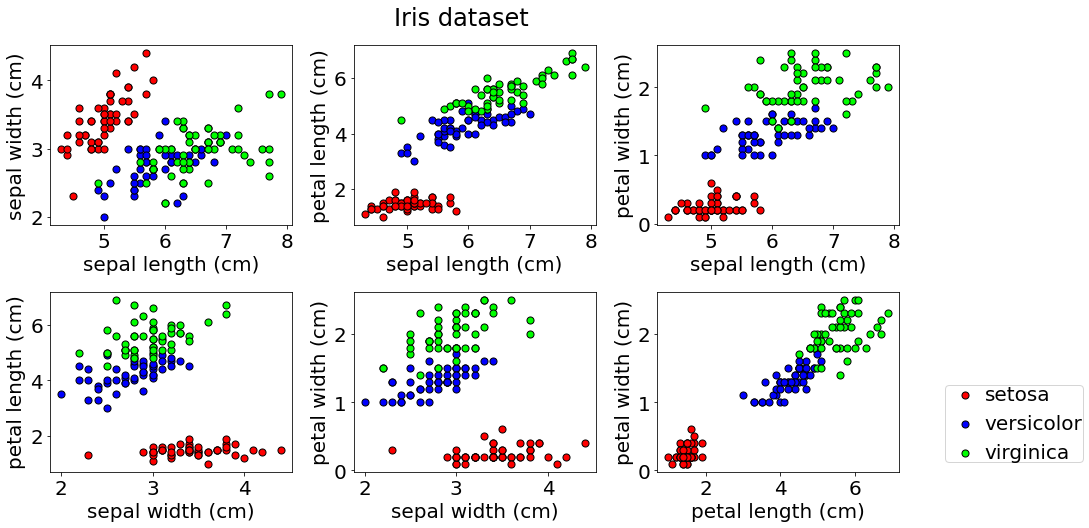

In [7]:
def plot_iris_dataset(model=None, verbose=False):
    """Visualization of the Iris dataset + classifier predictions"""
    
    n_classes = 3
    plot_colors = ['#FF0000', '#0000FF', '#00FF00']
    cmap = ListedColormap(plot_colors)

    plt.rcParams['font.size'] = 20
    fig, axs = plt.subplots(2, 3, figsize=(14, 8))

    for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
        if verbose: 
            print(f"\nPair [{pair[0]:d}, {pair[1]:d}]")
        
        X = iris.data[:, pair]
        y = iris.target

        ax = plt.subplot(2, 3, pairidx + 1)
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
        
        if model:
            # Data rescaling
            xmin = -1; xmax = 1
            X = MinMaxScaler(feature_range=(xmin, xmax), copy=False).fit_transform(X)
            
            # Train/Test subdivision
            train_size = 40; test_size = 20 
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, 
                train_size=train_size, test_size=test_size, 
                stratify=y,
                random_state=seed
            )
            
            # Fit functions
            clf = model(X_train, y_train, verbose=verbose)
           
            axes = [xmin, xmax, xmin, xmax]
            plot_predictions(clf, ax, axes, N=40, cmap=cmap)
            
            if verbose:
                if verbose:
                    print(f"Balanced Accuracy:")
                    print(f"\tTrain set: {metrics.balanced_accuracy_score(y_train, clf.predict(X_train)):.3f}")
                    print(f"\t Test set: {metrics.balanced_accuracy_score(y_test, clf.predict(X_test)):.3f}")

        for i, color in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            ax.scatter(
                X[idx, 0],
                X[idx, 1],
                c=color,
                label=iris.target_names[i],
                edgecolor="black",
                s=50,
            )

        ax.set_xlabel(iris.feature_names[pair[0]])
        ax.set_ylabel(iris.feature_names[pair[1]])

    plt.suptitle("Iris dataset")
    plt.legend(loc="lower right", borderpad=0, handletextpad=0, bbox_to_anchor=(1.8, 0.0))
    _ = plt.axis("tight")
    
plot_iris_dataset()

# RBF-SVM

In [10]:
def rbf_svc(X, y, verbose=False):
    
    # Create the parameter grid
    param_grid = {
        "gamma": [0.001, 0.01, 0.1, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0],
        "C": [1, 5, 10, 15, 20, 40, 60, 80, 100, 1000],
    }

    grid_search = GridSearchCV(SVC(kernel='rbf', random_state=42),
                               param_grid,
                               scoring='balanced_accuracy',
                               refit=True,
                               verbose=0,
                               cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
                               n_jobs=1)
    
    grid_search.fit(X, y)
    if verbose:
        print(f"CV best score: {grid_search.best_score_}")
        print(f"CV optimal hyperparameters: {grid_search.best_params_}")
        
    return grid_search.best_estimator_


Pair [0, 1]
CV best score: 0.7976190476190477
CV optimal hyperparameters: {'C': 5, 'gamma': 1.0}
Balanced Accuracy:
	Train set: 0.846
	 Test set: 0.810

Pair [0, 2]
CV best score: 0.9761904761904763
CV optimal hyperparameters: {'C': 100, 'gamma': 0.1}
Balanced Accuracy:
	Train set: 0.923
	 Test set: 0.952

Pair [0, 3]
CV best score: 0.9761904761904763
CV optimal hyperparameters: {'C': 1, 'gamma': 1.0}
Balanced Accuracy:
	Train set: 0.974
	 Test set: 0.857

Pair [1, 2]
CV best score: 0.9285714285714286
CV optimal hyperparameters: {'C': 5, 'gamma': 1.0}
Balanced Accuracy:
	Train set: 0.923
	 Test set: 0.905

Pair [1, 3]
CV best score: 0.9523809523809523
CV optimal hyperparameters: {'C': 1, 'gamma': 1.0}
Balanced Accuracy:
	Train set: 0.974
	 Test set: 0.857

Pair [2, 3]
CV best score: 0.9761904761904763
CV optimal hyperparameters: {'C': 1, 'gamma': 1.0}
Balanced Accuracy:
	Train set: 0.949
	 Test set: 0.905


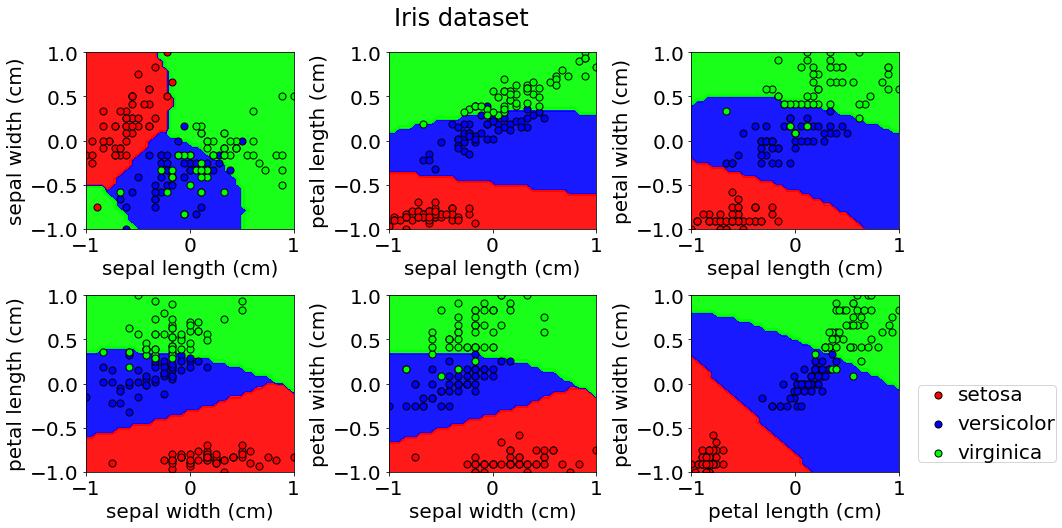

In [11]:
plot_iris_dataset(rbf_svc, verbose=True)

# QKE-SVM


Pair [0, 1]
     ┌───┐ ┌────────────┐     
q_0: ┤ H ├─┤ Rz(x[0]*α) ├──■──
     ├───┤ ├────────────┤  │  
q_1: ┤ H ├─┤ Rz(x[1]*α) ├──■──
     └───┘ └────────────┘     
Balanced Accuracy:
	Train set: 0.846
	 Test set: 0.762

Pair [0, 2]
     ┌───┐ ┌────────────┐     
q_0: ┤ H ├─┤ Rz(x[0]*α) ├──■──
     ├───┤ ├────────────┤  │  
q_1: ┤ H ├─┤ Rz(x[1]*α) ├──■──
     └───┘ └────────────┘     
Balanced Accuracy:
	Train set: 0.923
	 Test set: 0.905

Pair [0, 3]
     ┌───┐ ┌────────────┐     
q_0: ┤ H ├─┤ Rz(x[0]*α) ├──■──
     ├───┤ ├────────────┤  │  
q_1: ┤ H ├─┤ Rz(x[1]*α) ├──■──
     └───┘ └────────────┘     
Balanced Accuracy:
	Train set: 0.974
	 Test set: 0.905

Pair [1, 2]
     ┌───┐ ┌────────────┐     
q_0: ┤ H ├─┤ Rz(x[0]*α) ├──■──
     ├───┤ ├────────────┤  │  
q_1: ┤ H ├─┤ Rz(x[1]*α) ├──■──
     └───┘ └────────────┘     
Balanced Accuracy:
	Train set: 0.923
	 Test set: 0.857

Pair [1, 3]
     ┌───┐ ┌────────────┐     
q_0: ┤ H ├─┤ Rz(x[0]*α) ├──■──
     ├───┤ ├────────────┤  │  
q_

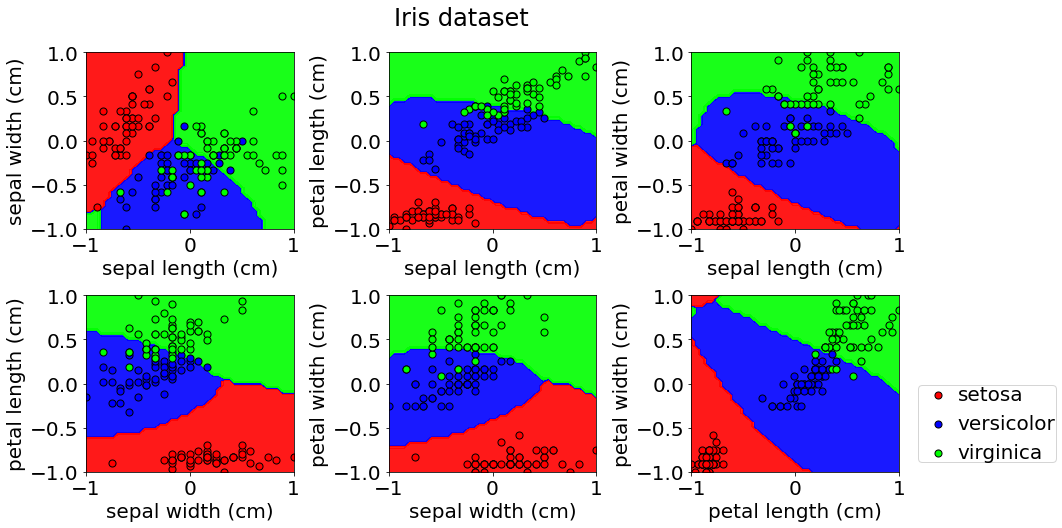

In [12]:
def qke_svc(X, y, verbose=False):

    ## Specify Feature Map
    fm = QuantumFeatureMap(
        num_features=len(X[0]), 
        num_qubits=2,
        num_layers=1,
        gates=['H', 'RZ', 'CZ', ], entanglement='linear',
    )
    if verbose: print(fm.draw(plot_barriers=False, fold=120))

    qsvc = OneVsRestClassifier(QSVC(fm, alpha=2.0, C=1.0, random_state=seed))
    qsvc.fit(X, y)
    return qsvc

plot_iris_dataset(qke_svc, verbose=True)


Pair [0, 1]
Best grid search parameters: {'C': 5, 'alpha': 1.0, 'feature_map': ['h', 'rz', 'cz'], 'n_layers': 1, 'n_qubits': 2}
Balanced Accuracy:
	Train set: 0.846
	 Test set: 0.762

Pair [0, 2]
Best grid search parameters: {'C': 20, 'alpha': 2.1999999999999997, 'feature_map': ['h', 'rz', 'cz'], 'n_layers': 1, 'n_qubits': 2}
Balanced Accuracy:
	Train set: 0.949
	 Test set: 0.952

Pair [0, 3]
Best grid search parameters: {'C': 1, 'alpha': 1.2, 'feature_map': ['h', 'rz', 'cz'], 'n_layers': 1, 'n_qubits': 2}
Balanced Accuracy:
	Train set: 0.949
	 Test set: 0.952

Pair [1, 2]
Best grid search parameters: {'C': 1, 'alpha': 2.1999999999999997, 'feature_map': ['h', 'rz', 'cz'], 'n_layers': 1, 'n_qubits': 2}
Balanced Accuracy:
	Train set: 0.923
	 Test set: 0.905

Pair [1, 3]
Best grid search parameters: {'C': 1, 'alpha': 2.5999999999999996, 'feature_map': ['h', 'rz', 'cz'], 'n_layers': 1, 'n_qubits': 2}
Balanced Accuracy:
	Train set: 0.974
	 Test set: 0.857

Pair [2, 3]
Best grid search para

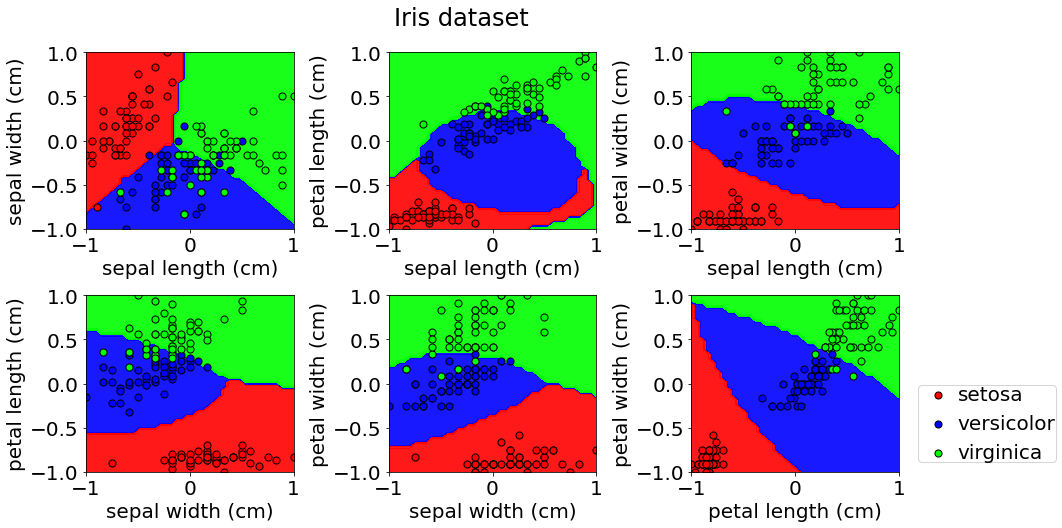

In [21]:
def qke_svc(X, y, verbose=False):

    param_grid = {
        # "alpha": [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0],
        "alpha": np.arange(0.8, 3.0, 0.2),
        "C": [1, 5, 10, 20],
        "n_layers": [1],
        "n_qubits": [2],
        "feature_map": [
                        ['h', 'rz', 'cz'], 
                       ],
    }

    gs = GridSearchCV(
        estimator=QKSVC(entanglement='linear', random_state=seed),
        param_grid=param_grid,
        scoring='balanced_accuracy',
        n_jobs=1,
        refit=True,
        cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=seed),
    )
    gs.fit(X, y)
    
    print('Best grid search parameters:', gs.best_params_)

    qsvc = OneVsRestClassifier(gs.best_estimator_)
    qsvc.fit(X, y)
    return qsvc

plot_iris_dataset(qke_svc, verbose=True)


Pair [0, 1]
Best grid search parameters: {'C': 5, 'alpha': 1.0, 'feature_map': ['h', 'rz', 'cz'], 'n_layers': 1, 'n_qubits': 2}
Balanced Accuracy:
	Train set: 0.846
	 Test set: 0.762

Pair [0, 2]
Best grid search parameters: {'C': 5, 'alpha': 1.4, 'feature_map': ['h', 'rz', 'cz'], 'n_layers': 1, 'n_qubits': 2}
Balanced Accuracy:
	Train set: 0.923
	 Test set: 0.905

Pair [0, 3]
Best grid search parameters: {'C': 1, 'alpha': 1.2, 'feature_map': ['h', 'rz', 'cz'], 'n_layers': 1, 'n_qubits': 2}
Balanced Accuracy:
	Train set: 0.949
	 Test set: 0.952

Pair [1, 2]
Best grid search parameters: {'C': 1, 'alpha': 2.1999999999999997, 'feature_map': ['h', 'rz', 'cz'], 'n_layers': 1, 'n_qubits': 2}
Balanced Accuracy:
	Train set: 0.923
	 Test set: 0.905

Pair [1, 3]
Best grid search parameters: {'C': 1, 'alpha': 2.5999999999999996, 'feature_map': ['h', 'rz', 'cz'], 'n_layers': 1, 'n_qubits': 2}
Balanced Accuracy:
	Train set: 0.974
	 Test set: 0.857

Pair [2, 3]
Best grid search parameters: {'C': 1,

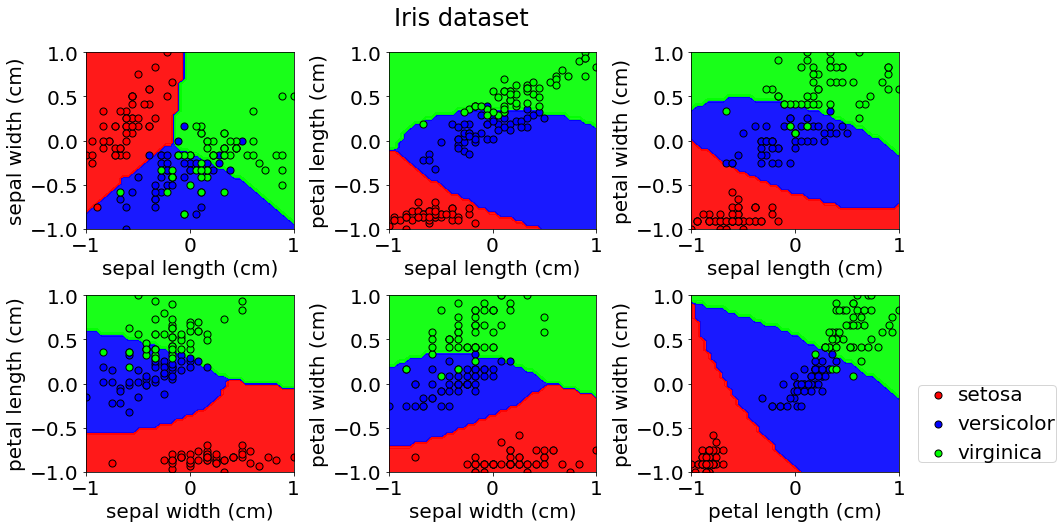

In [24]:
def qke_svc(X, y, verbose=False):

    param_grid = {
        # "alpha": [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0],
        "alpha": np.arange(0.8, 3.2, 0.2),
        "C": [1, 5],
        "n_layers": [1],
        "n_qubits": [2],
        "feature_map": [
                        ['h', 'rz', 'cz'], 
                       ],
    }

    gs = GridSearchCV(
        estimator=QKSVC(entanglement='linear', random_state=seed),
        param_grid=param_grid,
        scoring='balanced_accuracy',
        n_jobs=1,
        refit=True,
        cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=seed),
    )
    gs.fit(X, y)
    
    print('Best grid search parameters:', gs.best_params_)

    qsvc = OneVsRestClassifier(gs.best_estimator_)
    qsvc.fit(X, y)
    return qsvc

plot_iris_dataset(qke_svc, verbose=True)


Pair [0, 1]
Best grid search parameters: {'C': 5, 'alpha': 1.0, 'feature_map': ['rx', 'cz'], 'n_layers': 1, 'n_qubits': 2}
Balanced Accuracy:
	Train set: 0.846
	 Test set: 0.762

Pair [0, 2]
Best grid search parameters: {'C': 5, 'alpha': 1.5999999999999999, 'feature_map': ['rx', 'ry', 'cz'], 'n_layers': 1, 'n_qubits': 2}
Balanced Accuracy:
	Train set: 0.949
	 Test set: 0.905

Pair [0, 3]
Best grid search parameters: {'C': 1, 'alpha': 0.8, 'feature_map': ['rx', 'ry', 'cz'], 'n_layers': 1, 'n_qubits': 2}
Balanced Accuracy:
	Train set: 0.949
	 Test set: 0.905

Pair [1, 2]
Best grid search parameters: {'C': 5, 'alpha': 2.3999999999999995, 'feature_map': ['rx', 'ry', 'cz'], 'n_layers': 1, 'n_qubits': 2}
Balanced Accuracy:
	Train set: 0.923
	 Test set: 0.857

Pair [1, 3]
Best grid search parameters: {'C': 1, 'alpha': 2.5999999999999996, 'feature_map': ['rx', 'cz'], 'n_layers': 1, 'n_qubits': 2}
Balanced Accuracy:
	Train set: 0.974
	 Test set: 0.857

Pair [2, 3]
Best grid search parameters: 

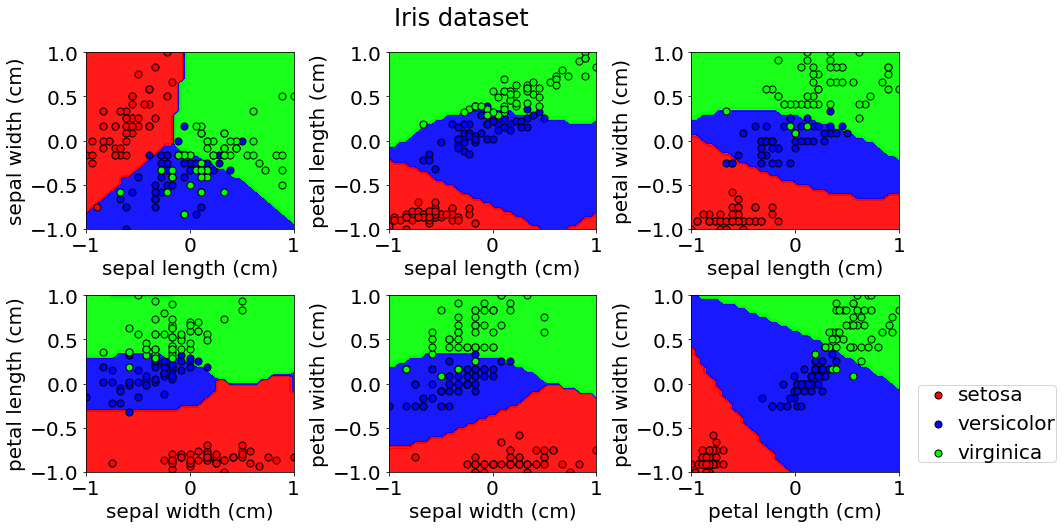

In [25]:
def qke_svc(X, y, verbose=False):

    param_grid = {
        "alpha": np.arange(0.8, 3.2, 0.2),
        "C": [1, 5],
        "n_layers": [1],
        "n_qubits": [2],
        "feature_map": [
                        ['rx', 'cz'], 
                        ['rx', 'swap'], 
                        ['rx', 'ry', 'cz'], 
                        ['rx', 'ry', 'swap'], 
                       ],
    }

    gs = GridSearchCV(
        estimator=QKSVC(entanglement='linear', random_state=seed),
        param_grid=param_grid,
        scoring='balanced_accuracy',
        n_jobs=1,
        refit=True,
        cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=seed),
    )
    gs.fit(X, y)
    
    print('Best grid search parameters:', gs.best_params_)

    qsvc = OneVsRestClassifier(gs.best_estimator_)
    qsvc.fit(X, y)
    return qsvc

plot_iris_dataset(qke_svc, verbose=True)